In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
input_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/mean_representational_distance/distance_matrix/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/comparison/'
object_path =  os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/occupied_corners/'

In [3]:
mouse_vector = [56165, 32363, 32364, 32365, 411857, 411857, 401714]
conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
sessions_random = [0,1,0,2,2,6,2] # total = 6
sessions_overlapping = [1,2,1,0,3,5,0] # total = 6
fixed_corner = [3,4,1,0,2,4,0]
sessions_stable = [2,0,2,0,1,4,1] # total = 5 (4 and 1/2)


In [4]:
random = []
overlapping = []
stable = []

random_dv = []
overlapping_dv = []
stable_dv = []

random_d = []
overlapping_d = []
stable_d = []

fixed_corner_data = []
occupied_corners_random = []
occupied_corners_stable = []
occupied_corners_overlapping = []
empty_corners_random = []
empty_corners_stable = []
empty_corners_overlapping = []

occupied_corners_overlapping_id = []

for i in [0,1,2,3,4,5,6]:
    mouse = mouse_vector[i]
    #### check session_random
    session = sessions_random[i]
    if session:
        file_name = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '_trial_based_1.npy'
        file_name2 = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '_trial_based_2.npy'
        file_name1 = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '.daily.npy'
        if os.path.isfile(file_name):
            distance = np.load(file_name)
            random.append(distance)
            objects_position_file = object_path + 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
            occupied_corners_random.append(np.load(objects_position_file))
            empty_corners_random.append(np.load(objects_position_file))
        if os.path.isfile(file_name1):
            distance = np.load(file_name1)
            random_d.append(distance)
        if os.path.isfile(file_name2):
            distance = np.load(file_name2)
            random_dv.append(distance)

    session = sessions_overlapping[i]
    if session:
        file_name = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '_trial_based_1.npy'
        file_name2 = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '_trial_based_2.npy'
        file_name1 = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '.daily.npy'
        if os.path.isfile(file_name) and os.path.isfile(file_name1):
            distance = np.load(file_name)
            fixed_corner_data.append(fixed_corner[i])
            overlapping.append(distance)
            objects_position_file = object_path + 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
            occupied_corners_overlapping.append(np.load(objects_position_file))
            empty_corners_overlapping.append(np.load(objects_position_file))
            occupied_corners_overlapping_id.append(np.load(objects_position_file))
        if os.path.isfile(file_name1):
            distance = np.load(file_name1)
            overlapping_d.append(distance)
        if os.path.isfile(file_name2):
            distance = np.load(file_name2)
            overlapping_dv.append(distance)
            
    session = sessions_stable[i]
    if session:
        file_name = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '_trial_based_1.npy'
        file_name2 = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '_trial_based_2.npy'
        file_name1 = input_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_' + f'{session}'+ '.daily.npy'
        if os.path.isfile(file_name) and os.path.isfile(file_name1):
            distance = np.load(file_name)
            stable.append(distance)
            objects_position_file = object_path + 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
            occupied_corners_stable.append(np.load(objects_position_file))
            empty_corners_stable.append(np.load(objects_position_file))
        if os.path.isfile(file_name1):
            distance = np.load(file_name1)
            stable_d.append(distance)
        if os.path.isfile(file_name2):
            distance = np.load(file_name2)
            stable_dv.append(distance)   
            
all_corners = [1,2,3,4]
index_corners_trial = np.zeros((4,2,20))
for corner in range(4):
    for day in range(4):
        for trial in range(5):
            i = day * 5 + trial
            if i < 19:
                index_corners_trial[corner,0,i] = int(day * 20 + trial * 4 + corner)
                index_corners_trial[corner,1,i] = int(day * 20 + (trial+1) * 4 + corner)      
index_corners_trial = index_corners_trial.astype(int)  

define_zero = [4,9,14,19]
for corner in range(4):
    index_corners_trial[corner][:,define_zero] = -1


In [5]:
########################## Z-SCORING ###############################3

def compute_zscore_distance(random):
    
    random_1 = []

    for i in range(len(random)):
        random_transf = []
        for j in range(6):
            x = random[i][j][np.nonzero(random[i][j])]
            concat = np.concatenate((x,x))
            distance_zs = (random[i][j] - np.mean(concat))/np.std(concat)
            distance_zs[np.where(random[i][j] == 0)] = 0 
            random_transf.append(distance_zs)
        random_1.append(np.array(random_transf))

    return random_1
    
random = compute_zscore_distance(random)
random_dv = compute_zscore_distance(random_dv)
random_d = compute_zscore_distance(random_d)

stable = compute_zscore_distance(stable)
stable_d = compute_zscore_distance(stable_d)
stable_dv = compute_zscore_distance(stable_dv)

overlapping = compute_zscore_distance(overlapping)
overlapping_d = compute_zscore_distance(overlapping_d)
overlapping_dv = compute_zscore_distance(overlapping_dv)


all_corners = [1,2,3,4]

for i in range(len(occupied_corners_random)):
    for trial in range(20):
        non_intersection = list(set(all_corners) ^ set(occupied_corners_random[i][:,trial]))
        occupied_corners_random[i][0,trial] = (occupied_corners_random[i][0,trial] + trial * 4 -1).astype(int)
        occupied_corners_random[i][1,trial] = (occupied_corners_random[i][1,trial] + trial * 4 -1).astype(int)
        empty_corners_random[i][0,trial] = non_intersection[0] + trial * 4 -1
        empty_corners_random[i][1,trial] = non_intersection[1] + trial * 4 -1    
        
for i in range(len(occupied_corners_stable)): 
    for trial in range(20):
        non_intersection = list(set(all_corners) ^ set(occupied_corners_stable[i][:,trial]))
        occupied_corners_stable[i][0,trial] = (occupied_corners_stable[i][0,trial] + trial * 4 -1).astype(int)
        occupied_corners_stable[i][1,trial] = (occupied_corners_stable[i][1,trial] + trial * 4 -1).astype(int)

        empty_corners_stable[i][0,trial] = non_intersection[0] + trial * 4 -1
        empty_corners_stable[i][1,trial] = non_intersection[1] + trial * 4 -1

occupied_corners_overlapping_d = []

for i in range(len(occupied_corners_overlapping)):
    occupied_corners_overlapping_d_i = np.zeros((4,))
    for day in range(4):
        occupied_corners_overlapping_d_i[day] = fixed_corner_data[i] + day *8 -1
    occupied_corners_overlapping_d.append(occupied_corners_overlapping_d_i)
    for trial in range(20):
        non_intersection = list(set(all_corners) ^ set(occupied_corners_overlapping[i][:,trial]))
        empty_corners_overlapping[i][0,trial] = non_intersection[0] + trial * 4 -1
        empty_corners_overlapping[i][1,trial] = non_intersection[1] + trial * 4 -1
        
        occupied_corners_overlapping_id[i][0,trial] = fixed_corner_data[i] + trial *4 -1
        
        if (occupied_corners_overlapping[i][0,trial] - fixed_corner_data[i])==0:
            occupied_corners_overlapping_id[i][1,trial] = (occupied_corners_overlapping[i][1,trial] + trial * 4 -1).astype(int)
        else:
            occupied_corners_overlapping_id[i][1,trial] = (occupied_corners_overlapping[i][0,trial] + trial * 4 -1).astype(int)

        occupied_corners_overlapping[i][0,trial] = (occupied_corners_overlapping[i][0,trial] + trial * 4 -1).astype(int)
        occupied_corners_overlapping[i][1,trial] = (occupied_corners_overlapping[i][1,trial] + trial * 4 -1).astype(int)
        

In [6]:
def comparison_selection(distance_list,positions1,positions2, cross= False):
    
    evolution_list = []
    for i in range(len(distance_list)):
        evolution_ = []
        for j in range(distance_list[0].shape[0]):
            if cross:
                evolution_.append(distance_list[i][j,(positions1[i][0,:]).astype(int),positions2[i][0,:].astype(int)])
                evolution_.append(distance_list[i][j,(positions1[i][0,:]).astype(int),positions2[i][1,:].astype(int)])
                evolution_.append(distance_list[i][j,(positions1[i][1,:]).astype(int),positions2[i][0,:].astype(int)])
                evolution_.append(distance_list[i][j,(positions1[i][1,:]).astype(int),positions2[i][1,:].astype(int)])
            else:
                evolution_.append(distance_list[i][j,(positions1[i][0,:]).astype(int),positions2[i][1,:].astype(int)])

        evolution_list.append(evolution_)
    return evolution_list

evolution_random_occupied = comparison_selection(random,occupied_corners_random,occupied_corners_random)
evolution_random_empty = comparison_selection(random,empty_corners_random,empty_corners_random)
evolution_random_cross = comparison_selection(random,occupied_corners_random,empty_corners_random,cross= True)

evolution_random_occupied_dv = comparison_selection(random_dv,occupied_corners_random,occupied_corners_random)
evolution_random_empty_dv = comparison_selection(random_dv,empty_corners_random,empty_corners_random)
evolution_random_cross_dv = comparison_selection(random_dv,occupied_corners_random,empty_corners_random,cross= True)


evolution_stable_occupied = comparison_selection(stable,occupied_corners_stable,occupied_corners_stable)
evolution_stable_empty = comparison_selection(stable,empty_corners_stable,empty_corners_stable)
evolution_stable_cross = comparison_selection(stable,occupied_corners_stable,empty_corners_stable, cross= True)

evolution_stable_occupied_dv = comparison_selection(stable_dv,occupied_corners_stable,occupied_corners_stable)
evolution_stable_empty_dv = comparison_selection(stable_dv,empty_corners_stable,empty_corners_stable)
evolution_stable_cross_dv = comparison_selection(stable_dv,occupied_corners_stable,empty_corners_stable, cross= True)


evolution_overlapping_occupied = comparison_selection(overlapping,occupied_corners_overlapping,occupied_corners_overlapping)
evolution_overlapping_empty = comparison_selection(overlapping,empty_corners_overlapping,empty_corners_overlapping)
evolution_overlapping_occupied_dv = comparison_selection(overlapping_dv,occupied_corners_overlapping,occupied_corners_overlapping)
evolution_overlapping_empty_dv = comparison_selection(overlapping_dv,empty_corners_overlapping,empty_corners_overlapping)


evolution_overlapping_cross_fix = []
evolution_overlapping_cross_mov = []
for j in range(overlapping[0].shape[0]):
    evolution_overlapping3_mov_ = []    
    evolution_overlapping3_fix_ = []    
    for i in range(len(overlapping)):
        evolution_overlapping3_mov_.append(overlapping[i][j,(occupied_corners_overlapping_id[i][1,:]).astype(int),empty_corners_overlapping[i][0,:].astype(int)])
        evolution_overlapping3_mov_.append(overlapping[i][j,(occupied_corners_overlapping_id[i][1,:]).astype(int),empty_corners_overlapping[i][1,:].astype(int)])

        evolution_overlapping3_fix_.append(overlapping[i][j,(occupied_corners_overlapping_id[i][0,:]).astype(int),empty_corners_overlapping[i][0,:].astype(int)])
        evolution_overlapping3_fix_.append(overlapping[i][j,(occupied_corners_overlapping_id[i][0,:]).astype(int),empty_corners_overlapping[i][1,:].astype(int)])
    evolution_overlapping_cross_fix.append(evolution_overlapping3_fix_)
    evolution_overlapping_cross_mov.append(evolution_overlapping3_mov_)
    

evolution_overlapping_cross_fix_dv = []
evolution_overlapping_cross_mov_dv = []
for j in range(overlapping[0].shape[0]):
    evolution_overlapping3_mov_ = []    
    evolution_overlapping3_fix_ = []    
    for i in range(len(overlapping)):
        evolution_overlapping3_mov_.append(overlapping_dv[i][j,(occupied_corners_overlapping_id[i][1,:]).astype(int),empty_corners_overlapping[i][0,:].astype(int)])
        evolution_overlapping3_mov_.append(overlapping_dv[i][j,(occupied_corners_overlapping_id[i][1,:]).astype(int),empty_corners_overlapping[i][1,:].astype(int)])

        evolution_overlapping3_fix_.append(overlapping_dv[i][j,(occupied_corners_overlapping_id[i][0,:]).astype(int),empty_corners_overlapping[i][0,:].astype(int)])
        evolution_overlapping3_fix_.append(overlapping_dv[i][j,(occupied_corners_overlapping_id[i][0,:]).astype(int),empty_corners_overlapping[i][1,:].astype(int)])
    evolution_overlapping_cross_fix_dv.append(evolution_overlapping3_fix_)
    evolution_overlapping_cross_mov_dv.append(evolution_overlapping3_mov_)

In [7]:
def evolution_corners(random_dv,index_corners_trial):

    evolution_random_cor1 = []
    for j in range(random_dv[0].shape[0]):
        evolution_random_cor1_ = []
        for corner in range(4):
            index = np.arange(0,index_corners_trial[corner].shape[1])
            for i in range(len(random_dv)):
                evolution_random_cor1_.append(random_dv[i][j,index_corners_trial[corner][0,index],index_corners_trial[corner][1,index]])
        evolution_random_cor1.append(evolution_random_cor1_)
        
    return evolution_random_cor1

evolution_random_corners = evolution_corners(random_dv,index_corners_trial)
evolution_overlapping_corners = evolution_corners(stable_dv,index_corners_trial)
evolution_stable_corners = evolution_corners(overlapping_dv,index_corners_trial)

In [8]:
def reshape_evolution(evolution):
    
    reshape_evolution = []
    
    for i in range(len(evolution)):
        r_evolution_ = []
        for j in range(len(evolution[i])):
            r_evolution_.append(evolution[i][j].reshape(4,5).T)
        reshape_evolution.append(r_evolution_)
    return reshape_evolution

def mean_evolution(evolution):
    
    mean_trial_evolution = []
    mean_day_evolution = []
 
    for i in range(len(evolution)):
        mean_trial_evolution_ = []
        mean_day_evolution_ = []
        for j in range(len(evolution[i])):
            trial_mean = np.mean(evolution[i][j],axis = 1)
            day_mean = np.mean(evolution[i][j],axis = 0)
            mean_trial_evolution_.append(trial_mean)
            mean_day_evolution_.append(day_mean)
        mean_trial_evolution.append(mean_trial_evolution_)
        mean_day_evolution.append(mean_day_evolution_)
        
    return [mean_trial_evolution, mean_day_evolution]

def compute_mean_evolution(evolution):
    
    reshape_evo = reshape_evolution(evolution)
    [a, b] = mean_evolution(reshape_evo)

    return a,b


[r_occ1, r_occ2] = compute_mean_evolution(evolution_random_occupied)
[r_emp1,r_emp2] = compute_mean_evolution(evolution_random_empty)
[r_cross1,r_cross2] = compute_mean_evolution(evolution_random_cross)

[s_occ1, s_occ2] = compute_mean_evolution(evolution_stable_occupied)
[s_emp1,s_emp2] = compute_mean_evolution(evolution_stable_empty)
[s_cross1,s_cross2] = compute_mean_evolution(evolution_stable_cross)

[o_occ1, o_occ2] = compute_mean_evolution(evolution_overlapping_occupied)
[o_emp1,o_emp2] = compute_mean_evolution(evolution_overlapping_empty)
[o_cross_fix1,o_cross_fix2] = compute_mean_evolution(evolution_overlapping_cross_fix)
[o_cross_mov1,o_cross_mov2] = compute_mean_evolution(evolution_overlapping_cross_mov)


[r_occ1_dv, r_occ2_dv] = compute_mean_evolution(evolution_random_occupied_dv)
[r_emp1_dv,r_emp2_dv] = compute_mean_evolution(evolution_random_empty_dv)
[r_cross1_dv,r_cross2_dv] = compute_mean_evolution(evolution_random_cross_dv)

[s_occ1_dv, s_occ2_dv] = compute_mean_evolution(evolution_stable_occupied_dv)
[s_emp1_dv,s_emp2_dv] = compute_mean_evolution(evolution_stable_empty_dv)
[s_cross1_dv,s_cross2_dv] = compute_mean_evolution(evolution_stable_cross_dv)

[o_occ1_dv, o_occ2_dv] = compute_mean_evolution(evolution_overlapping_occupied_dv)
[o_emp1_dv,o_emp2_dv] = compute_mean_evolution(evolution_overlapping_empty_dv)
[o_cross_fix1_dv,o_cross_fix2_dv] = compute_mean_evolution(evolution_overlapping_cross_fix_dv)
[o_cross_mov1_dv,o_cross_mov2_dv] = compute_mean_evolution(evolution_overlapping_cross_mov_dv)

In [9]:
random_occ_mean = np.mean(r_occ1,axis = 0)
random_empty_mean = np.mean(r_emp1,axis = 0)
random_cross_mean = np.mean(r_cross1,axis = 0)

random_occ_std = np.std(r_occ1,axis = 0)/np.sqrt(len(r_occ1))
random_empty_std = np.std(r_emp1,axis = 0)/np.sqrt(len(r_occ1))
random_cross_std = np.std(r_cross1,axis = 0)/np.sqrt(len(r_occ1))

stable_occ_mean = np.mean(s_occ1,axis = 0)
stable_empty_mean = np.mean(s_emp1,axis = 0)
stable_cross_mean = np.mean(s_emp1,axis = 0)
stable_occ_std = np.std(s_occ1,axis = 0)/np.sqrt(len(s_occ1))
stable_empty_std = np.std(s_emp1,axis = 0)/np.sqrt(len(s_occ1))
stable_cross_std = np.std(s_cross1,axis = 0)/np.sqrt(len(s_occ1))

overlapping_occ_mean = np.mean(o_occ1,axis = 0)
overlapping_empty_mean = np.mean(o_emp1,axis = 0)
overlapping_cross_fix_mean = np.mean(o_cross_fix1,axis = 0)
overlapping_cross_mov_mean = np.mean(o_cross_mov1,axis = 0)

overlapping_occ_std = np.std(o_occ1,axis = 0)/np.sqrt(len(o_occ1))
overlapping_empty_std = np.std(o_emp1,axis = 0)/np.sqrt(len(o_occ1))
overlapping_cross_fix_std = np.std(o_cross_fix1,axis = 0)/np.sqrt(len(o_occ1))
overlapping_cross_mov_std = np.std(o_cross_mov1,axis = 0)/np.sqrt(len(o_occ1))

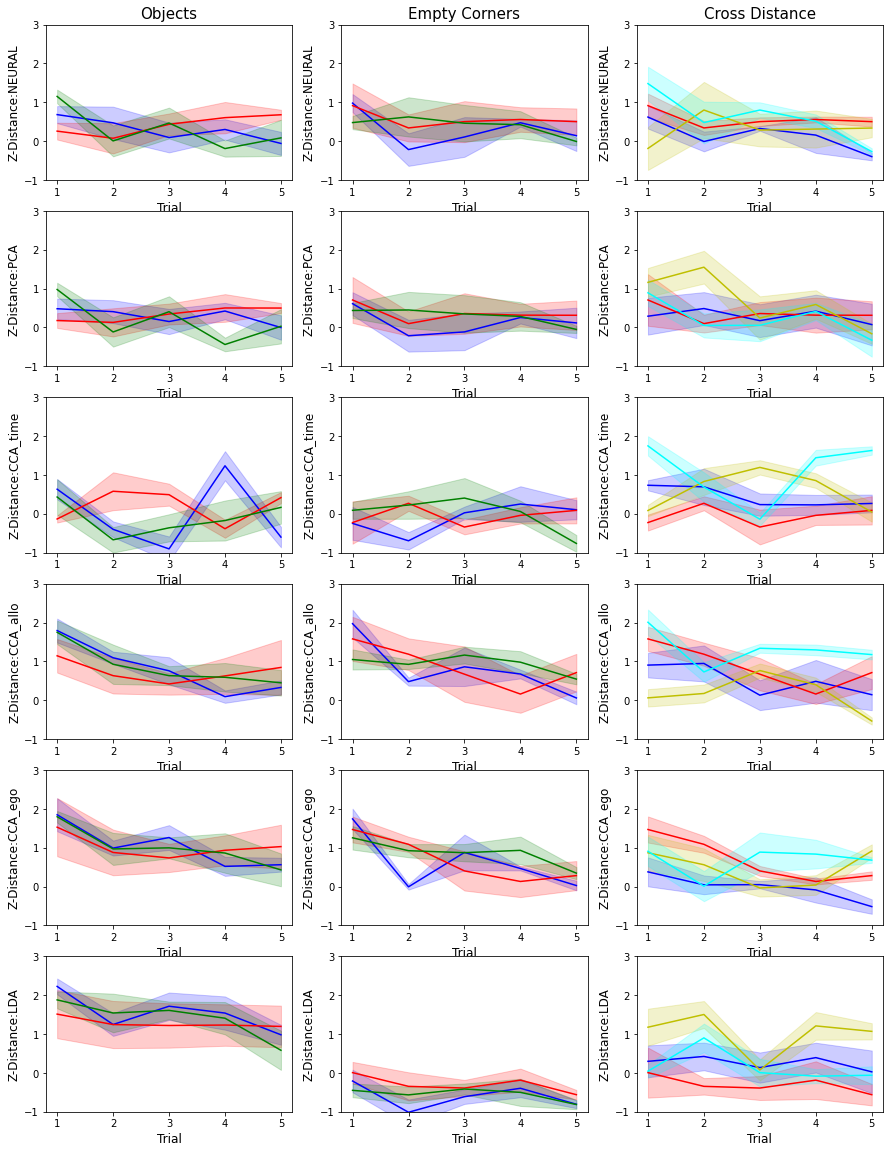

In [10]:
label = ['NEURAL','PCA','CCA_time','CCA_allo','CCA_ego','LDA']
titles = ['Objects','Empty Corners','Cross Distance']
figure, axes = plt.subplots(6,3)
trial_id = np.arange(1,6)

for i in range(6):
    
    axes[i,0].plot(trial_id,random_occ_mean[i,:], color = 'b')
    axes[i,1].plot(trial_id,random_empty_mean[i,:], color = 'b')
    axes[i,2].plot(trial_id,random_cross_mean[i,:], color = 'b')

    axes[i,0].plot(trial_id,stable_occ_mean[i,:], color = 'r')
    axes[i,1].plot(trial_id,stable_empty_mean[i,:], color = 'r')
    axes[i,2].plot(trial_id,stable_cross_mean[i,:], color = 'r')

    axes[i,0].plot(trial_id,overlapping_occ_mean[i,:], color = 'g')
    axes[i,1].plot(trial_id,overlapping_empty_mean[i,:], color = 'g')
    axes[i,2].plot(trial_id,overlapping_cross_fix_mean[i,:], color = 'y')
    axes[i,2].plot(trial_id,overlapping_cross_mov_mean[i,:], color = 'cyan')

    axes[i,0].fill_between(trial_id,random_occ_mean[i,:]-random_occ_std[i,:],random_occ_mean[i,:]+random_occ_std[i,:],alpha = 0.2, edgecolor = 'b', facecolor = 'b')
    axes[i,1].fill_between(trial_id,random_empty_mean[i,:]-random_empty_std[i,:],random_empty_mean[i,:]+random_empty_std[i,:],alpha = 0.2, edgecolor = 'b', facecolor = 'b')
    axes[i,2].fill_between(trial_id,random_cross_mean[i,:]-random_cross_std[i,:],random_cross_mean[i,:]+random_cross_std[i,:],alpha = 0.2, edgecolor = 'b', facecolor = 'b')

    axes[i,0].fill_between(trial_id,stable_occ_mean[i,:]-stable_occ_std[i,:],stable_occ_mean[i,:]+stable_occ_std[i,:],alpha = 0.2, edgecolor = 'r', facecolor = 'r')
    axes[i,1].fill_between(trial_id,stable_empty_mean[i,:]-stable_empty_std[i,:],stable_empty_mean[i,:]+stable_empty_std[i,:],alpha = 0.2, edgecolor = 'r', facecolor = 'r')
    axes[i,2].fill_between(trial_id,stable_cross_mean[i,:]-stable_cross_std[i,:],stable_cross_mean[i,:]+stable_cross_std[i,:],alpha = 0.2, edgecolor = 'r', facecolor = 'r')

    axes[i,0].fill_between(trial_id,overlapping_occ_mean[i,:]-overlapping_occ_std[i,:],overlapping_occ_mean[i,:]+overlapping_occ_std[i,:],alpha = 0.2, edgecolor = 'g', facecolor = 'g')
    axes[i,1].fill_between(trial_id,overlapping_empty_mean[i,:]-overlapping_empty_std[i,:],overlapping_empty_mean[i,:]+overlapping_empty_std[i,:],alpha = 0.2, edgecolor = 'g', facecolor = 'g')
    axes[i,2].fill_between(trial_id,overlapping_cross_fix_mean[i,:]-overlapping_cross_fix_std[i,:],overlapping_cross_fix_mean[i,:]+overlapping_cross_fix_std[i,:],alpha = 0.2, edgecolor = 'y', facecolor = 'y')
    axes[i,2].fill_between(trial_id,overlapping_cross_mov_mean[i,:]-overlapping_cross_mov_std[i,:],overlapping_cross_mov_mean[i,:]+overlapping_cross_mov_std[i,:],alpha = 0.2, edgecolor = 'cyan', facecolor = 'cyan')

    for j in range(3):
        axes[i,j].set_ylim([-1,3])
        axes[i,j].set_xlabel('Trial', fontsize = 12)
        axes[i,j].set_ylabel('Z-Distance:' + label[i], fontsize = 12)
        axes[0,j].set_title(titles[j],fontsize = 15)
        
figure.set_size_inches([15,20])

In [11]:
random_occ_mean = np.mean(r_occ2,axis = 0)
random_empty_mean = np.mean(r_emp2,axis = 0)
random_cross_mean = np.mean(r_cross2,axis = 0)

random_occ_std = np.std(r_occ2,axis = 0)/np.sqrt(len(r_occ1))
random_empty_std = np.std(r_emp2,axis = 0)/np.sqrt(len(r_occ1))
random_cross_std = np.std(r_cross2,axis = 0)/np.sqrt(len(r_occ1))

stable_occ_mean = np.mean(s_occ2,axis = 0)
stable_empty_mean = np.mean(s_emp2,axis = 0)
stable_cross_mean = np.mean(s_emp2,axis = 0)
stable_occ_std = np.std(s_occ2,axis = 0)/np.sqrt(len(s_occ1))
stable_empty_std = np.std(s_emp2,axis = 0)/np.sqrt(len(s_occ1))
stable_cross_std = np.std(s_cross2,axis = 0)/np.sqrt(len(s_occ1))

overlapping_occ_mean = np.mean(o_occ2,axis = 0)
overlapping_empty_mean = np.mean(o_emp2,axis = 0)
overlapping_cross_fix_mean = np.mean(o_cross_fix2,axis = 0)
overlapping_cross_mov_mean = np.mean(o_cross_mov2,axis = 0)

overlapping_occ_std = np.std(o_occ2,axis = 0)/np.sqrt(len(o_occ1))
overlapping_empty_std = np.std(o_emp2,axis = 0)/np.sqrt(len(o_occ1))
overlapping_cross_fix_std = np.std(o_cross_fix2,axis = 0)/np.sqrt(len(o_occ1))
overlapping_cross_mov_std = np.std(o_cross_mov2,axis = 0)/np.sqrt(len(o_occ1))

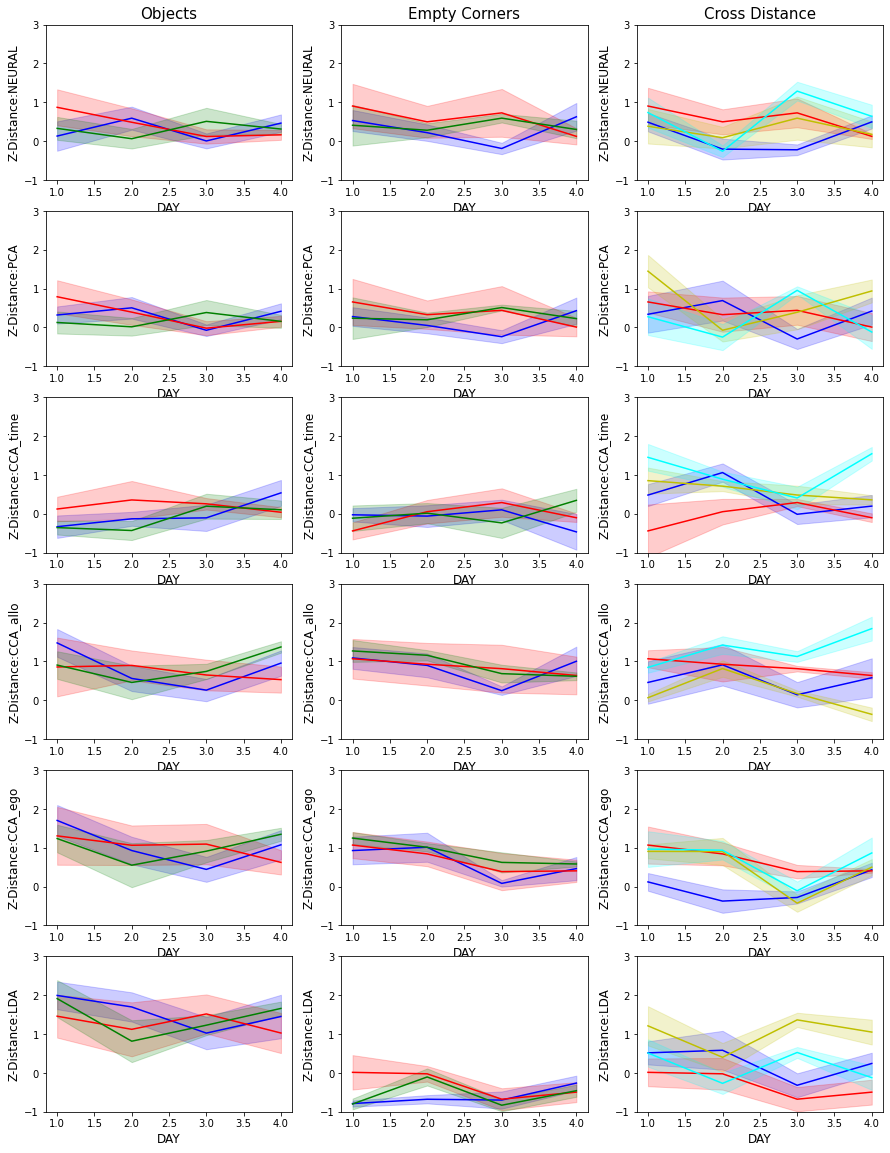

In [12]:
label = ['NEURAL','PCA','CCA_time','CCA_allo','CCA_ego','LDA']
titles = ['Objects','Empty Corners','Cross Distance']
figure, axes = plt.subplots(6,3)
trial_id = np.arange(1,5)

for i in range(6):
    
    axes[i,0].plot(trial_id,random_occ_mean[i,:], color = 'b')
    axes[i,1].plot(trial_id,random_empty_mean[i,:], color = 'b')
    axes[i,2].plot(trial_id,random_cross_mean[i,:], color = 'b')

    axes[i,0].plot(trial_id,stable_occ_mean[i,:], color = 'r')
    axes[i,1].plot(trial_id,stable_empty_mean[i,:], color = 'r')
    axes[i,2].plot(trial_id,stable_cross_mean[i,:], color = 'r')

    axes[i,0].plot(trial_id,overlapping_occ_mean[i,:], color = 'g')
    axes[i,1].plot(trial_id,overlapping_empty_mean[i,:], color = 'g')
    axes[i,2].plot(trial_id,overlapping_cross_fix_mean[i,:], color = 'y')
    axes[i,2].plot(trial_id,overlapping_cross_mov_mean[i,:], color = 'cyan')

    axes[i,0].fill_between(trial_id,random_occ_mean[i,:]-random_occ_std[i,:],random_occ_mean[i,:]+random_occ_std[i,:],alpha = 0.2, edgecolor = 'b', facecolor = 'b')
    axes[i,1].fill_between(trial_id,random_empty_mean[i,:]-random_empty_std[i,:],random_empty_mean[i,:]+random_empty_std[i,:],alpha = 0.2, edgecolor = 'b', facecolor = 'b')
    axes[i,2].fill_between(trial_id,random_cross_mean[i,:]-random_cross_std[i,:],random_cross_mean[i,:]+random_cross_std[i,:],alpha = 0.2, edgecolor = 'b', facecolor = 'b')

    axes[i,0].fill_between(trial_id,stable_occ_mean[i,:]-stable_occ_std[i,:],stable_occ_mean[i,:]+stable_occ_std[i,:],alpha = 0.2, edgecolor = 'r', facecolor = 'r')
    axes[i,1].fill_between(trial_id,stable_empty_mean[i,:]-stable_empty_std[i,:],stable_empty_mean[i,:]+stable_empty_std[i,:],alpha = 0.2, edgecolor = 'r', facecolor = 'r')
    axes[i,2].fill_between(trial_id,stable_cross_mean[i,:]-stable_cross_std[i,:],stable_cross_mean[i,:]+stable_cross_std[i,:],alpha = 0.2, edgecolor = 'r', facecolor = 'r')

    axes[i,0].fill_between(trial_id,overlapping_occ_mean[i,:]-overlapping_occ_std[i,:],overlapping_occ_mean[i,:]+overlapping_occ_std[i,:],alpha = 0.2, edgecolor = 'g', facecolor = 'g')
    axes[i,1].fill_between(trial_id,overlapping_empty_mean[i,:]-overlapping_empty_std[i,:],overlapping_empty_mean[i,:]+overlapping_empty_std[i,:],alpha = 0.2, edgecolor = 'g', facecolor = 'g')
    axes[i,2].fill_between(trial_id,overlapping_cross_fix_mean[i,:]-overlapping_cross_fix_std[i,:],overlapping_cross_fix_mean[i,:]+overlapping_cross_fix_std[i,:],alpha = 0.2, edgecolor = 'y', facecolor = 'y')
    axes[i,2].fill_between(trial_id,overlapping_cross_mov_mean[i,:]-overlapping_cross_mov_std[i,:],overlapping_cross_mov_mean[i,:]+overlapping_cross_mov_std[i,:],alpha = 0.2, edgecolor = 'cyan', facecolor = 'cyan')

    for j in range(3):
        axes[i,j].set_ylim([-1,3])
        axes[i,j].set_xlabel('DAY', fontsize = 12)
        axes[i,j].set_ylabel('Z-Distance:' + label[i], fontsize = 12)
        axes[0,j].set_title(titles[j],fontsize = 15)
        
figure.set_size_inches([15,20])

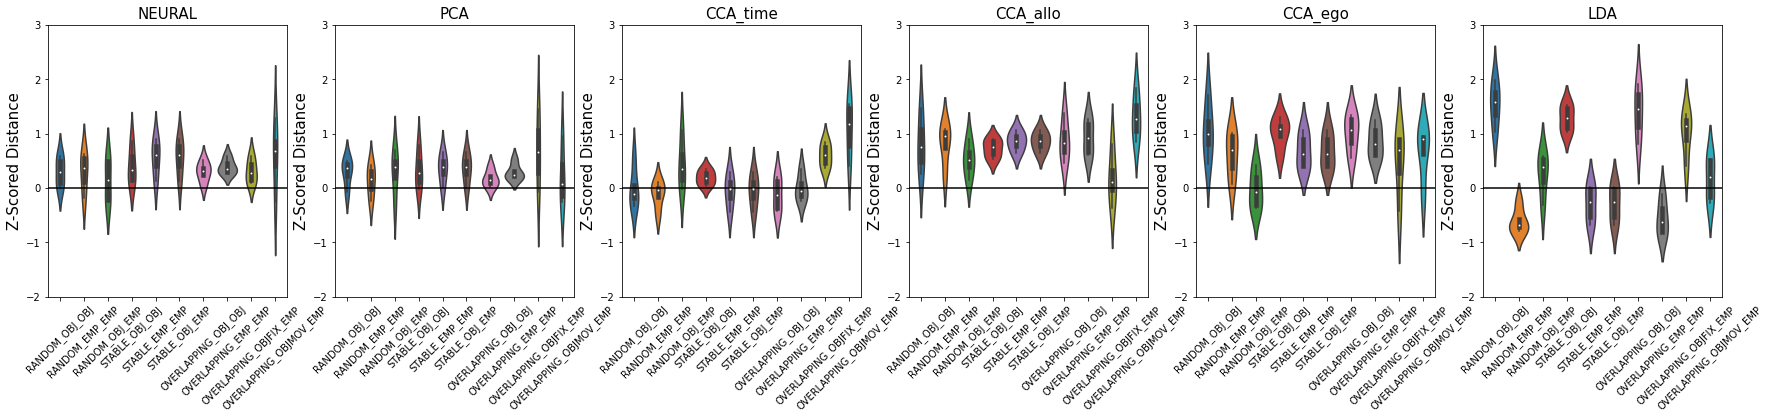

In [13]:
figure = plt.figure()
gs = plt.GridSpec(1,6)
label2 = ['RANDOM_OBJ_OBJ','RANDOM_EMP_EMP','RANDOM_OBJ_EMP','STABLE_OBJ_OBJ','STABLE_EMP_EMP','STABLE_OBJ_EMP','OVERLAPPING_OBJ_OBJ','OVERLAPPING_EMP_EMP','OVERLAPPING_OBJFIX_EMP','OVERLAPPING_OBJMOV_EMP']
label3 = ['RANDOM_OBJ_OBJ','RANDOM_EMP_EMP','RANDOM_OBJ_EMP','STABLE_OBJ_OBJ','STABLE_EMP_EMP','STABLE_OBJ_EMP','OVERLAPPING_OBJ_OBJ_MOV','OVERLAPPING_OBJ_OBJ_FIX','OVERLAPPING_EMP_EMP','OVERLAPPING_OBJMOV_EMP','OVERLAPPING_OBJFIX_EMP']

for i in range(6):
    
    plot_list = [[random_occ_mean[i]],[random_empty_mean[i]],[random_cross_mean[i]],[stable_occ_mean[i]],[stable_empty_mean[i]],
                 [stable_cross_mean[i]],[overlapping_occ_mean[i]],[overlapping_empty_mean[i]],[overlapping_cross_fix_mean[i]],
                 [overlapping_cross_mov_mean[i]]]
    
    ax1 = figure.add_subplot(gs[0,i])
    ax1.set_title(label[i],fontsize = 15)
    #ax1.set_xlabel('Conditions', fontsize = 15)
    ax1.set_ylabel('Z-Scored Distance',fontsize = 15)
    ax1 = sns.violinplot(data = plot_list, orient = 'v')
    ax1.set_xticklabels(label2)
    ax1.set_xticklabels(label2)
    ax1.set_ylim([-2,3])
    ax1.axhline(y=0, color='k', linestyle='-')

    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
        
figure.set_size_inches([30,5])
figure_name = 'representational_distance_evolution_mean.png'
figure.patch.set_facecolor('white')

figure.savefig(figure_path + figure_name)

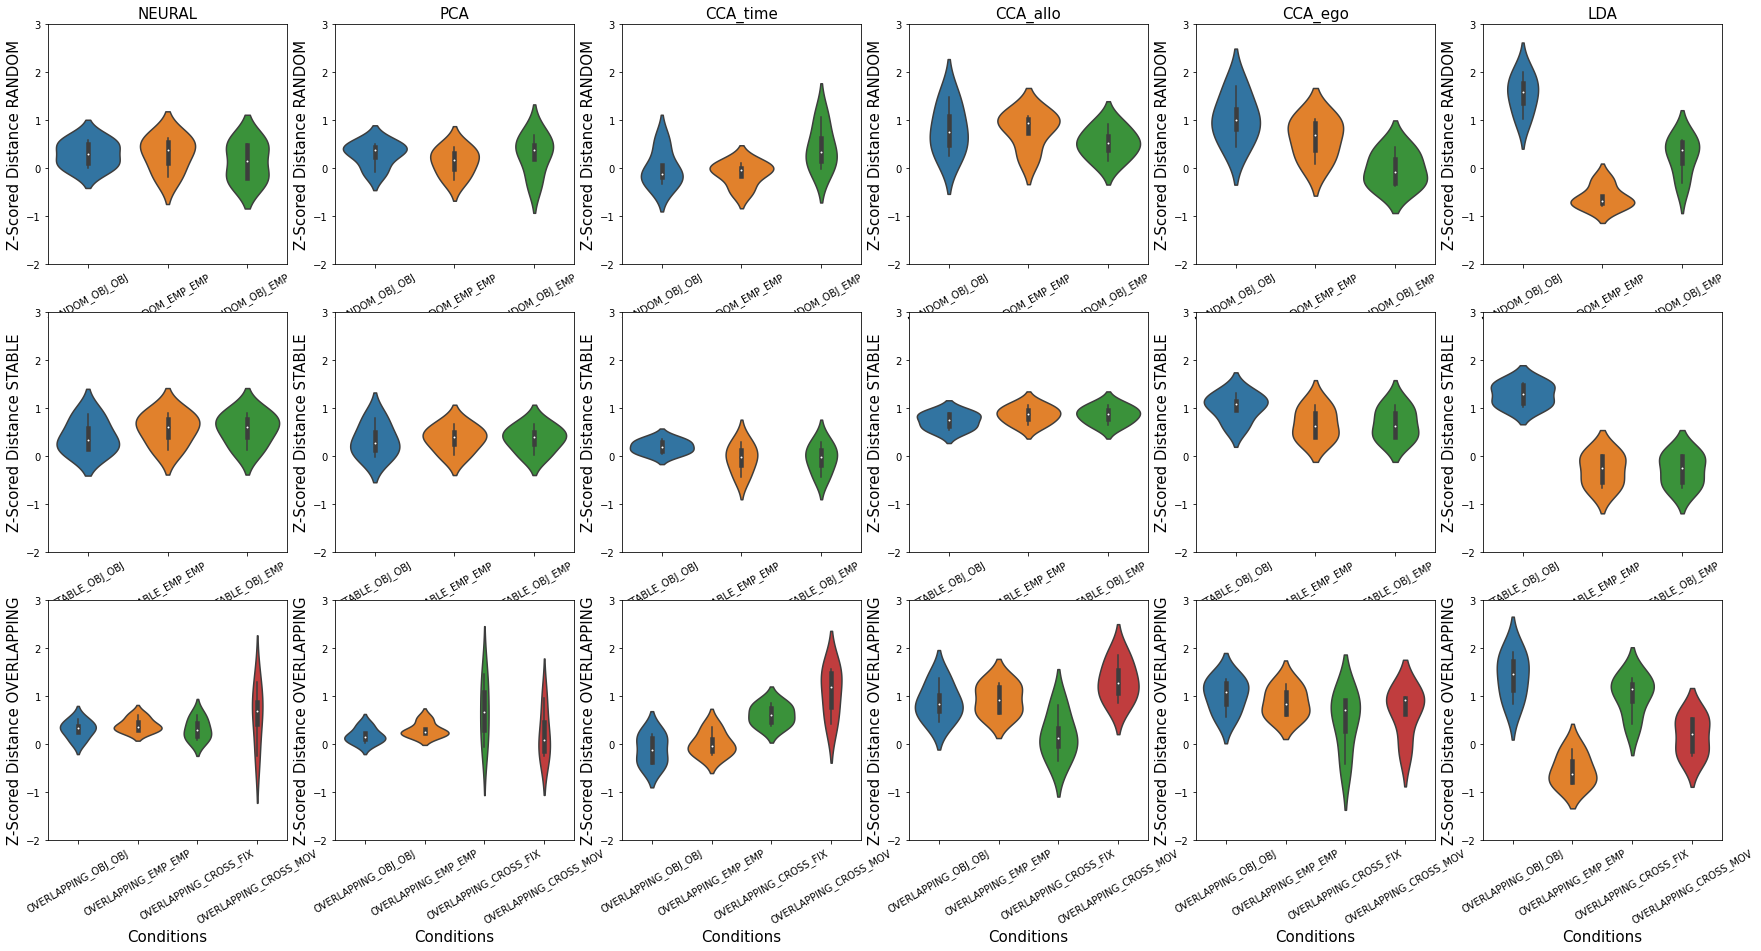

In [14]:
figure = plt.figure()
gs = plt.GridSpec(3,6)

label_random = ['RANDOM_OBJ_OBJ','RANDOM_EMP_EMP','RANDOM_OBJ_EMP']
label_stable = ['STABLE_OBJ_OBJ','STABLE_EMP_EMP','STABLE_OBJ_EMP']
label_overlapping = ['OVERLAPPING_OBJ_OBJ','OVERLAPPING_EMP_EMP','OVERLAPPING_CROSS_FIX','OVERLAPPING_CROSS_MOV']

for i in range(6):
    
    plot_list = [[random_occ_mean[i]],[random_empty_mean[i]],[random_cross_mean[i]]]
    
    ax1 = figure.add_subplot(gs[0,i])
    ax1.set_title(label[i],fontsize = 15)
    #ax1.set_xlabel('Conditions', fontsize = 15)
    ax1.set_ylabel('Z-Scored Distance RANDOM',fontsize = 15)
    ax1 = sns.violinplot(data = plot_list, orient = 'v')
    ax1.set_xticklabels(label_random)
    ax1.set_ylim([-2,3])
    for tick in ax1.get_xticklabels():
        tick.set_rotation(30)
        
    plot_list = [[stable_occ_mean[i]],[stable_empty_mean[i]],[stable_cross_mean[i]]]
                     
    ax1 = figure.add_subplot(gs[1,i])
    #ax1.set_title(label[i],fontsize = 15)
    ax1.set_xlabel('Conditions', fontsize = 15)
    ax1.set_ylabel('Z-Scored Distance STABLE',fontsize = 15)
    ax1 = sns.violinplot(data = plot_list, orient = 'v')
    ax1.set_xticklabels(label_stable)
    ax1.set_ylim([-2,3])
    for tick in ax1.get_xticklabels():
        tick.set_rotation(30)
        
    plot_list = [[overlapping_occ_mean[i]],[overlapping_empty_mean[i]],[overlapping_cross_fix_mean[i]],[overlapping_cross_mov_mean[i]]]
    ax1 = figure.add_subplot(gs[2,i])
    #ax1.set_title(label[i],fontsize = 15)
    ax1.set_xlabel('Conditions', fontsize = 15)
    ax1.set_ylabel('Z-Scored Distance OVERLAPPING',fontsize = 15)
    ax1 = sns.violinplot(data = plot_list, orient = 'v')
    ax1.set_xticklabels(label_overlapping)
    ax1.set_ylim([-2,3])
    for tick in ax1.get_xticklabels():
        tick.set_rotation(30)
        
figure.set_size_inches([30,15])
figure_name = 'representational_distance_evolution_mean_2.png'
figure.patch.set_facecolor('white')

figure.savefig(figure_path + figure_name)

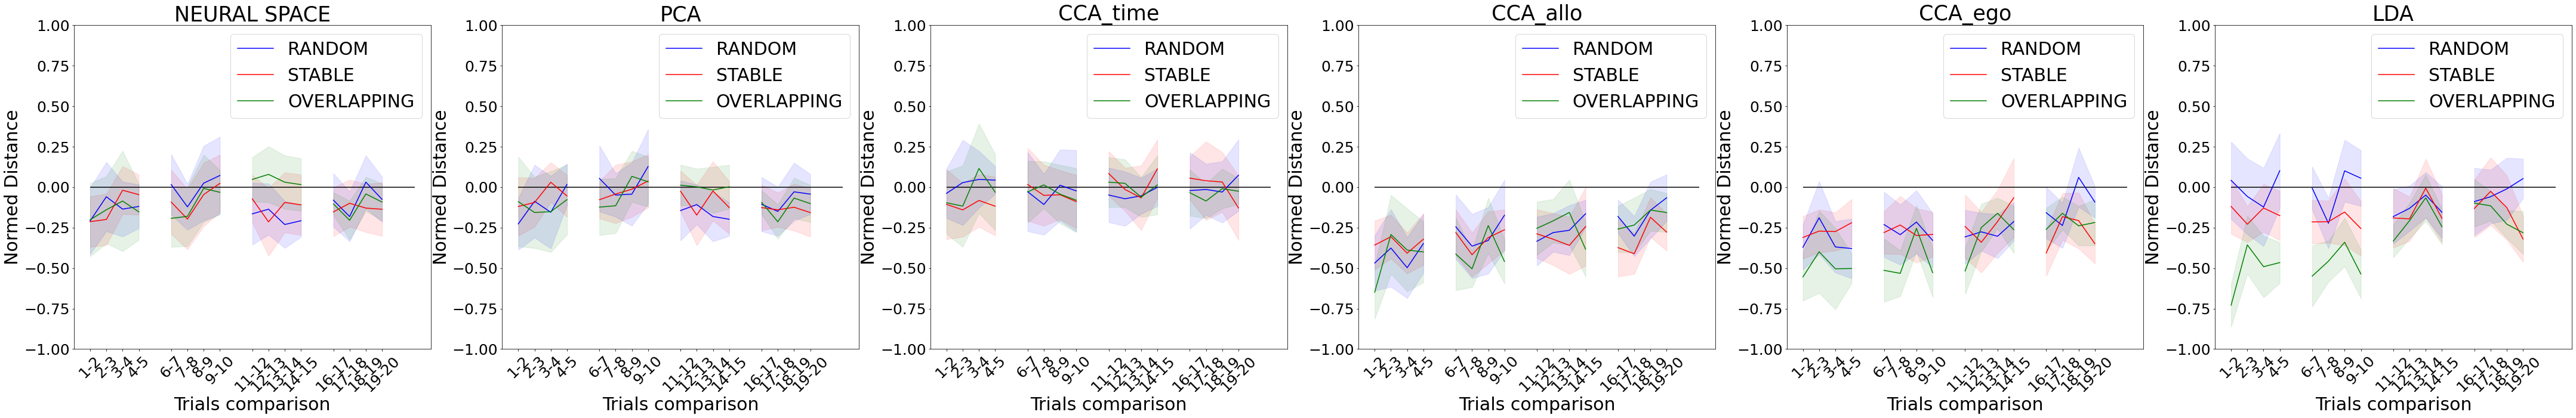

In [15]:
random_mean = np.mean(evolution_random_corners, axis = 1)
random_std =  np.std(evolution_random_corners,axis = 1)/np.sqrt(len(evolution_random_corners[0]))

stable_mean = np.mean(evolution_stable_corners, axis = 1)
stable_std =  np.std(evolution_stable_corners,axis = 1)/np.sqrt(len(evolution_stable_corners[0]))

overlapping_mean = np.mean(evolution_overlapping_corners, axis = 1)
overlapping_std =  np.std(evolution_overlapping_corners,axis = 1)/np.sqrt(len(evolution_overlapping_corners[0]))


figure, axes = plt.subplots(1,6)
time = np.arange(1,21)
label = ['NEURAL SPACE','PCA','CCA_time','CCA_allo','CCA_ego','LDA']
 
trials_comparison = ['1-2','2-3','3-4','4-5','6-7','7-8','8-9','9-10','11-12','12-13','13-14','14-15','16-17','17-18','18-19','19-20']  
trials_comparison_pos = [0,1,2,3,5,6,7,8,10,11,12,13,15,16,17,18]

for i in range(6):
    for day in range(4):
        time = np.arange(day * 5,day*5+4)
        axes[i].plot(time,random_mean[i][time],'b')
        axes[i].plot(time,stable_mean[i][time],'r')
        axes[i].plot(time,overlapping_mean[i][time],'g')

        axes[i].fill_between(time,stable_mean[i][time]-stable_std[i][time],stable_mean[i][time]+stable_std[i][time],alpha = 0.1, edgecolor = 'r', facecolor = 'r')
        axes[i].fill_between(time,random_mean[i][time]-random_std[i][time],random_mean[i][time]+random_std[i][time],alpha = 0.1, edgecolor = 'b', facecolor = 'b')
        axes[i].fill_between(time,overlapping_mean[i][time]-overlapping_std[i][time],overlapping_mean[i][time]+overlapping_std[i][time],alpha = 0.1, edgecolor = 'g', facecolor = 'g')

        
    axes[i].set_ylim([-1,1])
    axes[i].set_ylabel('Normed Distance',fontsize = 30)
    axes[i].set_xlabel('Trials comparison',fontsize = 30)
    axes[i].set_xticks(trials_comparison_pos)
    axes[i].set_xticklabels(trials_comparison, fontsize = 20)
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
    axes[i].hlines(0,0,20,color = 'k')
        
    axes[i].set_title(label[i], fontsize = 35)
    axes[i].legend(['RANDOM','STABLE','OVERLAPPING'], fontsize = 30)

#figure.suptitle('Corners Representational Distance Evolution', fontsize = 25)
    
figure.set_size_inches([75,10])
figure_name = 'representational_distance_evolution_corners_mean.png'
figure.patch.set_facecolor('white')

figure.savefig(figure_path + figure_name)   

In [16]:
[r_occ1_dv, r_occ2_dv] = compute_mean_evolution(evolution_random_corners)
[s_occ1_dv, s_occ2_dv] = compute_mean_evolution(evolution_stable_corners)
[o_occ1_dv, o_occ2_dv] = compute_mean_evolution(evolution_overlapping_corners)

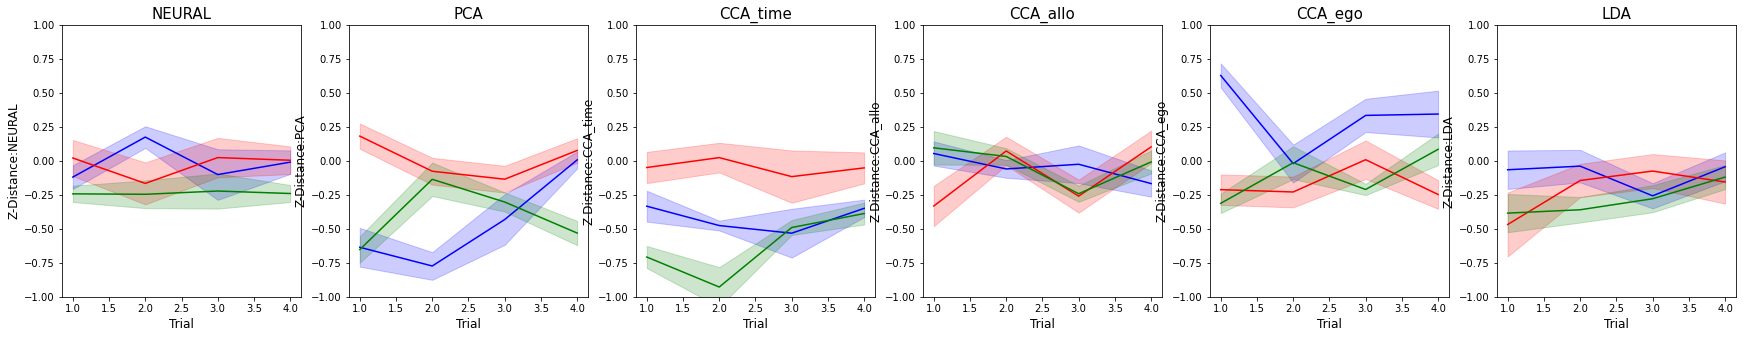

In [17]:
random_cor_mean = np.mean(r_occ1_dv,axis = 0)
random_cor_std = np.std(r_occ1_dv,axis = 0)/np.sqrt(len(r_occ1_dv))
stable_cor_mean = np.mean(s_occ1_dv,axis = 0)
stable_cor_std = np.std(s_occ1_dv,axis = 0)/np.sqrt(len(s_occ1_dv))
overlapping_cor_mean = np.mean(o_occ1_dv,axis = 0)
overlapping_cor_std = np.std(o_occ1_dv,axis = 0)/np.sqrt(len(o_occ1_dv))


label = ['NEURAL','PCA','CCA_time','CCA_allo','CCA_ego','LDA']
titles = ['Objects','Empty Corners','Cross Distance']
figure, axes = plt.subplots(1,6)
trial_id = np.arange(1,5)

for i in range(6):
    
    axes[i].plot(trial_id,random_cor_mean[i,0:4], color = 'b')
    axes[i].plot(trial_id,stable_cor_mean[i,0:4], color = 'r')
    axes[i].plot(trial_id,overlapping_cor_mean[i,0:4], color = 'g')
    axes[i].fill_between(trial_id,random_cor_mean[i,0:4]-random_cor_std[i,0:4],random_cor_mean[i,0:4]+random_cor_std[i,0:4],alpha = 0.2, edgecolor = 'b', facecolor = 'b')
    axes[i].fill_between(trial_id,stable_cor_mean[i,0:4]-stable_cor_std[i,0:4],stable_cor_mean[i,0:4]+stable_cor_std[i,0:4],alpha = 0.2, edgecolor = 'r', facecolor = 'r')
    axes[i].fill_between(trial_id,overlapping_cor_mean[i,0:4]-overlapping_cor_std[i,0:4],overlapping_cor_mean[i,0:4]+overlapping_cor_std[i,0:4],alpha = 0.2, edgecolor = 'g', facecolor = 'g')

    axes[i].set_ylim([-1,1])
    axes[i].set_xlabel('Trial', fontsize = 12)
    axes[i].set_ylabel('Z-Distance:' + label[i], fontsize = 12)
    axes[i].set_title(label[i],fontsize = 15)
        
figure.set_size_inches([30,5])

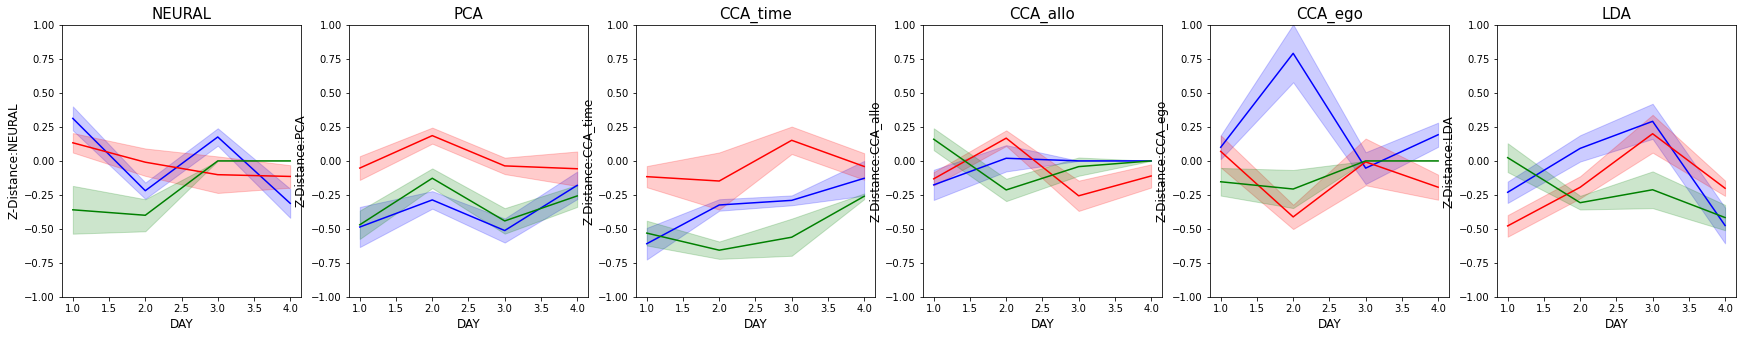

In [18]:
random_cor_mean = np.mean(r_occ2_dv,axis = 0)
random_cor_std = np.std(r_occ2_dv,axis = 0)/np.sqrt(len(r_occ2_dv))
stable_cor_mean = np.mean(s_occ2_dv,axis = 0)
stable_cor_std = np.std(s_occ2_dv,axis = 0)/np.sqrt(len(s_occ2_dv))
overlapping_cor_mean = np.mean(o_occ2_dv,axis = 0)
overlapping_cor_std = np.std(o_occ2_dv,axis = 0)/np.sqrt(len(o_occ2_dv))


label = ['NEURAL','PCA','CCA_time','CCA_allo','CCA_ego','LDA']
titles = ['Objects','Empty Corners','Cross Distance']
figure, axes = plt.subplots(1,6)
trial_id = np.arange(1,5)

for i in range(6):
    
    axes[i].plot(trial_id,random_cor_mean[i,0:4], color = 'b')
    axes[i].plot(trial_id,stable_cor_mean[i,0:4], color = 'r')
    axes[i].plot(trial_id,overlapping_cor_mean[i,0:4], color = 'g')
    axes[i].fill_between(trial_id,random_cor_mean[i,0:4]-random_cor_std[i,0:4],random_cor_mean[i,0:4]+random_cor_std[i,0:4],alpha = 0.2, edgecolor = 'b', facecolor = 'b')
    axes[i].fill_between(trial_id,stable_cor_mean[i,0:4]-stable_cor_std[i,0:4],stable_cor_mean[i,0:4]+stable_cor_std[i,0:4],alpha = 0.2, edgecolor = 'r', facecolor = 'r')
    axes[i].fill_between(trial_id,overlapping_cor_mean[i,0:4]-overlapping_cor_std[i,0:4],overlapping_cor_mean[i,0:4]+overlapping_cor_std[i,0:4],alpha = 0.2, edgecolor = 'g', facecolor = 'g')

    axes[i].set_ylim([-1,1])
    axes[i].set_xlabel('DAY', fontsize = 12)
    axes[i].set_ylabel('Z-Distance:' + label[i], fontsize = 12)
    axes[i].set_title(label[i],fontsize = 15)
        
figure.set_size_inches([30,5])

In [19]:
occupied_corners_random_flag = []
for i in range(len(occupied_corners_random)):
    binary_array = np.zeros((4,20))
    for j in range(20):
        obj1 = occupied_corners_random[i][0,j].astype(int)%4
        obj2 = occupied_corners_random[i][1,j].astype(int)%4
        binary_array[obj1,j] = 1
        binary_array[obj2,j] = 1
    occupied_corners_random_flag.append(binary_array)
    
occupied_corners_stable_flag = []
for i in range(len(occupied_corners_stable)):
    binary_array = np.zeros((4,20))
    for j in range(20):
        obj1 = occupied_corners_stable[i][0,j].astype(int)%4
        obj2 = occupied_corners_stable[i][1,j].astype(int)%4
        binary_array[obj1,j] = 1
        binary_array[obj2,j] = 1
    occupied_corners_stable_flag.append(binary_array)

occupied_corners_overlapping_flag = []
occupied_corners_overlapping_mov_flag = []
occupied_corners_overlapping_fix_flag = []
for i in range(len(occupied_corners_overlapping)):
    binary_array_mov = np.zeros((4,20))
    binary_array0 = np.zeros((4,20))
    binary_array_fix = np.zeros((4,20))
    for j in range(20):
        obj0 = occupied_corners_overlapping_id[i][0,j].astype(int)%4
        obj1 = occupied_corners_overlapping_id[i][1,j].astype(int)%4
        
        #print(occupied_corners_overlapping_id[i][0,j]-occupied_corners_overlapping_id[i][1,j])
        binary_array0[obj0,j] = 1
        binary_array0[obj1,j] = 1
        
        binary_array_mov[obj1,j] = 1
        binary_array_fix[obj0,j] = 1
        
    occupied_corners_overlapping_flag.append(binary_array0)        
    occupied_corners_overlapping_mov_flag.append(binary_array_mov)
    occupied_corners_overlapping_fix_flag.append(binary_array_fix)    

In [20]:
evolution_random_nav = []
evolution_overlapping_nav = []
evolution_stable_nav = []

evolution_random_obj = []
evolution_overlapping_obj_fix = []
evolution_overlapping_obj_mov = []
evolution_stable_obj = []

for i in range(len(random)):
    evolution_random_nav_ = []
    evolution_random_obj_ = []
    for j in range(random[0].shape[0]):
        
        obj_array = np.empty((20,))
        obj_array[:] = np.nan
        nav_array = np.empty((20,))
        nav_array[:] = np.nan
        
        for corner in range(4):
            diff = np.diff(occupied_corners_random_flag[i][corner,:],append = 0)
            consecutive_trials = np.logical_and(occupied_corners_random_flag[i][corner,:]==1,diff==0)
            index_obj = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_obj)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_obj)[0]]
            obj_array[index_obj] = random_dv[i][j,index1,index2]
            
            consecutive_trials = np.logical_and(occupied_corners_random_flag[i][corner,:]==0,diff==0)
            index_nav = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_nav)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_nav)[0]]
            nav_array[index_nav] =  random_dv[i][j,index1,index2]
            
        evolution_random_obj_.append(obj_array)
        evolution_random_nav_.append(nav_array)
    evolution_random_obj.append(evolution_random_obj_)
    evolution_random_nav.append(evolution_random_nav_)  

for i in range(len(stable)):
    evolution_stable_nav_ = []
    evolution_stable_obj_ = []
    for j in range(stable[0].shape[0]):
        
        obj_array = np.empty((20,))
        obj_array[:] = np.nan
        nav_array = np.empty((20,))
        nav_array[:] = np.nan
        
        for corner in range(4):
            diff = np.diff(occupied_corners_stable_flag[i][corner,:],append = 0)
            consecutive_trials = np.logical_and(occupied_corners_stable_flag[i][corner,:]==1,diff==0)
            index_obj = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_obj)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_obj)[0]]
            positions = np.where(index_obj==True)
            obj_array[positions] = stable_dv[i][j,index1,index2]
            
            consecutive_trials = np.logical_and(occupied_corners_stable_flag[i][corner,:]==0,diff==0)
            index_nav = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_nav)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_nav)[0]]
            nav_array[index_nav] =  stable_dv[i][j,index1,index2]
        evolution_stable_obj_.append(obj_array)
        evolution_stable_nav_.append(nav_array)
    evolution_stable_obj.append(evolution_stable_obj_)
    evolution_stable_nav.append(evolution_stable_nav_)  


for i in range(len(overlapping)):
    evolution_overlapping_nav_ = []
    evolution_overlapping_obj_fix_ = []
    evolution_overlapping_obj_mov_ = []
    
    for j in range(stable[0].shape[0]):
        
        obj_array_mov = np.empty((20,))
        obj_array_mov[:] = np.nan
        obj_array_fix = np.empty((20,))
        obj_array_fix[:] = np.nan
        nav_array = np.empty((20,))
        nav_array[:] = np.nan
        
        for corner in range(4):
            diff = np.diff(occupied_corners_overlapping_mov_flag[i][corner,:],append = 0)
            consecutive_trials = np.logical_and(occupied_corners_overlapping_mov_flag[i][corner,:]==1,diff==0)
            #print(consecutive_trials)
            index_obj = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_obj)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_obj)[0]]
            positions = np.where(index_obj==True)
            # print(i)
            # print(positions)
            obj_array_mov[positions] = overlapping_dv[i][j,index1,index2]
            
            diff = np.diff(occupied_corners_overlapping_fix_flag[i][corner,:],append = 0)
            consecutive_trials = np.logical_and(occupied_corners_overlapping_fix_flag[i][corner,:]==1,diff==0)
            index_obj = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_obj)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_obj)[0]]
            positions = np.where(index_obj==True)
            obj_array_fix[positions] = overlapping_dv[i][j,index1,index2]
            
            diff = np.diff(occupied_corners_overlapping_flag[i][corner,:],append = 0)
            consecutive_trials = np.logical_and(occupied_corners_overlapping_flag[i][corner,:]==0,diff==0)
            index_nav = np.logical_and(index_corners_trial[corner][0,:]>=0,consecutive_trials)
            index1 = index_corners_trial[corner][0,np.where(index_nav)[0]]
            index2 = index_corners_trial[corner][1,np.where(index_nav)[0]]
            nav_array[index_nav] =  overlapping_dv[i][j,index1,index2]
            
        evolution_overlapping_obj_mov_.append(obj_array_mov)
        evolution_overlapping_obj_fix_.append(obj_array_fix)
        evolution_overlapping_nav_.append(nav_array)
        
    evolution_overlapping_obj_mov.append(evolution_overlapping_obj_mov_)
    evolution_overlapping_obj_fix.append(evolution_overlapping_obj_fix_)
    evolution_overlapping_nav.append(evolution_overlapping_nav_)
